# Projet phylogénétique
Marine Djaffardjy (marine.djaffardjy@u-psud.fr)- Théophile Sanchez - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous étudierez trois espèces disparues de félins qui vivaient autrefois sur le continent Américain. Ces trois espèces, le _smilodon_ (tigre à dents de sabre), l'_homotherium_ (_scimitar toothed tigers_) et _M. trumani_ (guépard américain) se sont éteintes il y a environ 13 000 ans, à la fin de la dernière période glaciaire. Des séquences ADN partielles de la protéine cytochrome b de ces espèces ont pu être séquencées et vont vous permettre de retrouver les liens de parentés entre ces espèces et des espèces de félins contemporaines : le chat domestique, le lion, le léopard, le tigre, le puma, le guépard et les chats sauvages africains, chinois et européens. Sont aussi présentes dans le jeu de donnée des séquences issues d'espèces extérieures aux félins.

Afin de reconstruire l'arbre phylogénétique de ces espèces, vous utiliserez une méthode basée sur le calcul des distances évolutives entre les séquences ADN des protéines. Sachez qu'une démarche similaire peut-être appliquée aux séquences d'acides aminés.

Les différentes étapes qui vous permetterons de construire l'arbre sont détaillées dans ce notebook. Vous devrez implémenter les algorithmes en Python et répondre aux questions dans les cellules prévues.

Quelques conseils :
- Utiliser au maximum les fonctions présentes dans les packages de python (sauf si il vous est explicitement demandé de les réimplémenter). Si un problème vous paraît courant, il existe surement déjà une fonction pour le résoudre. Pour ce projet vous serez limités aux packages de base, à Numpy et ETE (seulement pour l'affichage des arbres). Vous n'avez pas besoin d'utiliser d'autre packages (pas de pandas).
- Si une partie de votre code ne vous semble pas très explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- Faites des fonctions d'affichage pour vos matrices !!
- N'hésitez pas à chercher dans la documentation et sur internet. Cependant, faites attention au plagiat !

Le projet est à rendre **en binôme** par mail. Vous regrouperez votre notebook et les fichiers nécessaires à son fonctionnement dans une archive portant vos noms et prénoms (il faut que je puisse faire tourner les notebooks).

------
## Importation des séquences

Le format [FASTA](https://fr.wikipedia.org/wiki/FASTA_(format_de_fichier) permet de stocker plusieurs séquences (ADN, ARN ou peptidiques) dans un fichier. Les séquences que vous allez étudier ont été regroupées dans le fichier `cat_dna.fasta`.

**Exercice 1 :** Écrivez une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire `seq_cat`. Les clés seront les noms des séquences et les valeurs du dictionnaire seront les séquences d'adn.
Exportez le dictionnaire obtenu dans un fichier `output/dict_seq.json`.

In [1]:
# Importe toutes les bibliothèques du projets
import json
import numpy as np
from ete3 import Tree, TreeStyle

In [2]:
def load_fasta(filepath: str, toJson: bool=False, remove_par: bool=True) -> dict:
    """
    Charge un fichier Fasta à partir d'un chemin de fichier et le convertit en dictionnaire ou JSON.

    Args:
        filepath (str): Chemin d'accès au fichier Fasta
        toJson (bool, optional): Indique si le dictionnaire doit être converti en JSON. Par défaut, False.
        remove_par (bool, optional): Permet de supprimer les parenthèses des clefs des séquences. Par défauts, True. 

    Returns:
        dict: dictionnaire des séquences Fasta. Si toJson est True, retourne le dictionnaire sous forme de chaîne JSON.

    Example:
        fdict = load_fasta("sequences.fasta", True)
    """
    f = open(filepath, "r")
    f_str = f.read()
    f_sections = f_str.split(">")[1:]
    f_dict = {}

    # Créer le dictionnaire
    for sect in f_sections:
        key_val = sect.split("\n")
        key = key_val[0]
        val = "".join(key_val[1:])
        
        # Supprime les charactères parenthèses.
        if remove_par:
            key = key.replace("(", "")
            key = key.replace(")", "")
        
        f_dict[key] = val

    # Transforme en fichier JSON.
    if toJson:
        f_dict = json.dumps(f_dict)

    return f_dict

In [3]:
FASTA = load_fasta("./input/cat_dna.fasta")

print(f"Dog DNA : {FASTA['Dog DNA'][:10]}...")
print(f"Wolf DNA: {FASTA['Wolf DNA'][:10]}...")

Dog DNA : CTAGCCAAAA...
Wolf DNA: CTAGCCAAAA...


------
## Alignement des séquences

La méthode que vous utiliserez pour calculer l'arbre phylogénétique nécessite de calculer la distance évolutive entre les séquences. Avant de pouvoir les calculer, il faut d'abord aligner les séquences en considérant trois types de mutations :
- les substitutions (un nucléotide est remplacé par un autre)
- les insertions
- les délétions
Par exemple, les séquences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Le "-" désigne un *gap*, c'est à dire un "trou" dans l'alignement qui a été causé par une insertion ou une déletion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent à une multitude d'histoires phylogénétiques différentes. Pour sélectionner le meilleur alignement il faut donc introduire l'hypothèse du maximum de parcimonie qui privilégie l'histoire phylogénétique qui implique le moins d'hypothèses et donc, le moins de changements évolutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au scénario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant définir un score d'identité que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au modèle d'évolution de l'ADN défini par Jukes et Cantor qui fait l'hypothèse d'un taux de mutation équivalent pour chacun des nucléotides. Cependant, en réalité ces taux ne sont pas les mêmes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est différent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait être pris en compte comme la fréquence du nucléotide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de modèles différents d'écrivant l'évolution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarité $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** Écriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarité précédente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est déjà fournie, la matrice de similarité est stockée dans le fichier `dna_matrix` :


In [4]:
class SimilarityMatrix:
    """
    Une classe pour représenter une matrice de similarité de séquences d'acides aminés

    Args:
        letters (list) : Liste des lettres représentant les acides aminés.
        values (numpy array) : Matrice de similarité, avec des scores de similarité entre les acides aminés.

    Methods:
        init(self, filename) : Initialise la matrice de similarité en lisant un fichier de similarité.
        score(self, letter1, letter2) : Retourne le score de similarité entre letter1 et letter2.
        compute_score(self, seq1, seq2) : Calcule et retourne le score total de similarité entre les séquences seq1 et seq2.
    """

    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(
                filename, skiprows=1, usecols=range(1, len(self.letters) + 1))

    def score(self, letter1, letter2):  # return the similarity score between letter1 and letter2
        """
        Retourne le score de similarité entre letter1 et letter2.

        Args:
            letter1 (str) : La première lettre représentant un acide aminé à comparer.
            letter2 (str) : La deuxième lettre représentant un acide aminé à comparer.

        Returns:
            score (int) : Score de similarité entre letter1 et letter2.

        Example:
        matrix = SimilarityMatrix("similarity_matrix.txt")
        score = matrix.score("A", "A")
        """
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]

    def compute_score(self, seq1, seq2):
        """
        Calcule et retourne le score total de similarité entre les séquences seq1 et seq2.

        Args:
            seq1 (str) : La première séquence d'acides aminés à comparer.
            seq2 (str) : La deuxième séquence d'acides aminés à comparer.

        Returns:
            seq_scores (int) : Score total de similarité entre les séquences seq1 et seq2.

        Exemple:
            matrix = SimilarityMatrix("similarity_matrix.txt")
            seq_scores = matrix.compute_score("AAA", "AAA")
        """
        seq_len = len(seq1)
        seq_scores = 0
        for i in range(seq_len):
            seq_scores += self.score(seq1[i], seq2[i])

        return seq_scores


# Example
similarity_matrix = SimilarityMatrix('input/dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))


Score between G and C: -5.0
Score between A and a gap: -5.0


In [5]:
# Calcule le score de similarité entre les séquences suivantes.
seq = "ATCTCGTGA"
seq_1 = "-ACTCCTGA"
seq_2 = "A-CTCCTGA"
seq_3 = "AC-TCCTGA"

print('Score bettween A1:', similarity_matrix.compute_score(seq, seq_1))
print('Score bettween A2:', similarity_matrix.compute_score(seq, seq_2))
print('Score bettween A3:', similarity_matrix.compute_score(seq, seq_3))


Score bettween A1: 35.0
Score bettween A2: 49.0
Score bettween A3: 39.0


------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarité et comment calculer le score de similarité d'un alignement, vous allez devoir implémenter un algorithme permettant de trouver le meilleur alignement global entre deux séquences. Avec deux séquences à aligner de taille $n$ et $m$, la première étape consiste à initialiser deux matrices de taille $(n+1) \times (m+1)$. La première est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les séquences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarité entre deux nucléotides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a été calculé en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a été calculé en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a été calculé en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier élément $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-même, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'à arriver au 'o'. Un 'd' correspond à un *match* entre les deux séquences, 'l' à un *gap* dans la séquence $A$ et 'u' à un *gap* dans la séquence $B$. En revenant à l'exemple précédent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond à l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Implémenter l'algorithme de Needlman et Wunsch. Il prendra en paramètre deux séquences et une matrice de similarité et retournera leur alignement. Tester le avec les séquences "ACTCCTGA" et "ATCTCGTGA".

In [6]:
def needlmanWunsch(seq_a: str, seq_b: str, mat_similar) -> tuple:
    """
    Retourne l'alignement optimal entre seqA et seqB en utilisant l'algorithme de Needleman-Wunsch.

    Paramètres:
        seqA (str) : La première séquence à aligner.
        seqB (str) : La deuxième séquence à aligner.
        mat_similar (SimilarityMatrix) : Matrice de similarité utilisée pour évaluer la similitude entre les acides aminés.

    Returns:
        (str, str) : Un tuples des alignement optimal de seqA et seqB.

    Example:
        matrix = SimilarityMatrix("similarity_matrix.txt")
        seqA = "AGCT"
        seqB = "AACT"
        align = needlmanWunsch(seqA, seqB, similarMatrix=matrix)
    """
    # Définit le nombre de lignes et de colonnes de la matrice.
    line = len(seq_a) + 1
    col = len(seq_b) + 1

    # Récupère le score de gap.
    score_gap = int(mat_similar.score(seq_a[0], "-"))

    # Initialise les matrices M et T.
    mat_m = np.zeros((line, col))
    mat_t = np.full((line, col), " ")

    # Définit les valeurs initiaux pour la matrice M.
    mat_m[0] = np.arange(0, score_gap*col, score_gap)
    mat_m[:, :1] = np.arange(0, score_gap*line, score_gap).reshape((line, 1))

    # Définit les valeurs initiales pour la matrice T
    mat_t[0] = np.full((1, col), "l")
    mat_t[:, :1] = np.full((line, 1), "u")
    mat_t[0, 0] = "o"

    # Remplit la matrice M et T.
    for i in range(1, line):
        for j in range(1, col):
            # Calcule les valeurs suivant la formule.
            val_d = mat_m[i-1, j-1] + mat_similar.score(seq_a[i-1], seq_b[j-1])
            val_l = mat_m[i, j-1] + mat_similar.score(seq_a[i-1], "-")
            val_u = mat_m[i-1, j] + mat_similar.score(seq_b[j-1], "-")

            mat_m[i, j] = max(val_d, val_l, val_u)

            # Assigne les valeurs de la matrice de T.
            if mat_m[i, j] == val_d:
                mat_t[i, j] = "d"

            elif mat_m[i, j] == val_l:
                mat_t[i, j] = "l"

            elif mat_m[i, j] == val_u:
                mat_t[i, j] = "u"

    # Algorithme pour calculer l'alignement en suivant la matrice T.
    # Indice sur les cases.
    i, j = line-1, col-1

    # Indice des séquences pour calculer l'alignement.
    k_a, k_b = len(seq_a) - 1, len(seq_b) - 1

    cur_letter, align_a, align_b = "", "", ""
    is_end = False

    # On stope lorsqu'on rencontre une lettre 'o'.
    while not is_end:
        # On récupère la lettre de la case i, j.
        cur_letter = mat_t[i, j]

        # On compare la lettre i, j avec les lettres 'd', 'u' et 'l'.
        # On se déplace en diagonale.
        if cur_letter == "d":
            align_a += seq_a[k_a]
            align_b += seq_b[k_b]
            i, j = i - 1, j - 1
            k_a, k_b = k_a - 1, k_b - 1

        # On se déplace d'une case à gauche.
        elif cur_letter == "l":
            align_a += "-"
            align_b += seq_b[k_b]
            j -= 1
            k_b = k_b - 1

        # On se déplace d'une case en haut.
        elif cur_letter == "u":
            align_a += seq_a[k_a]
            align_b += "-"
            i -= 1
            k_a = k_a - 1
        
        # On stoppe la boucle.
        else:
            is_end = True
        
    return align_a[::-1], align_b[::-1]


In [7]:
# Calcule l'alignement des séquences suivantes :
needlmanWunsch("ACTCCTGA", "ATCTCGTGA", similarity_matrix)

('A-CTCCTGA', 'ATCTCGTGA')

----
## Matrice de distance

Dans le cas de séquences très proches, on estime que la distance évolutive réelle entre les séquences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucléotide. Pour simplifier, on ignore les positions alignées à des gaps. On applique ensuite la correction de Jukes-Cantor. Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 4 :** Implémenter la fonction retournant la matrice de distance à partir d'un dictionnaire de séquences. 

In [8]:
def distance_sequence(seq1: str, seq2: str) -> float:
    """
    Calcule la distance de deux séquences de caractères.

    Args :
        seq1 (str) : La première séquence.
        seq2 (str) : La deuxième séquence.

    Returns :
        float : La distance entre les deux séquences.
    
    Errors:
        Les séquences seq1 et seq2 doivent avoir la même taille.
    """
    if len(seq1) != len(seq2): assert "Les séquences doivent avoir la même taille."
    
    p_distance = 0

    # Calcule la p_distance des séquences.
    cpt = 0
    for i in range(len(seq1)):
        if seq1[i] != seq2[i] and seq1[i] != "-" and seq2[i] != "-":
            p_distance += 1    

        #on ignore les gaps   
        if seq1[i] == "-":
            cpt += 1
            
        if seq2[i] == "-":
            cpt += 1

    p_distance /= len(seq1) - cpt
    return -3/4*np.log(1-4/3 * p_distance)


def mat_distance(dict_seq: dict) -> np.ndarray:
    """
    Calculer la matrice de distance entre toutes les séquences dans un dictionnaire de séquences donné.

    Args:
        dictSeq (dict): Dictionnaire de séquences où les clés sont les noms des séquences 
        et les valeurs sont les séquences réelles.
    
    Returns: 
        numpy.ndarray : matrice de distance de taille n x n où n est le nombre de séquences dans le dictionnaire.
    """
    # Récupère les clefs des séquences.
    keys = np.array(list(dict_seq.keys()))
    n = len(keys) + 1
    keys = np.insert(keys, 0, f"({n}, {n})")

    # Ajoutes les indices qui corresponds au clefs.

    mat_dist = np.zeros((n, n), dtype=object)
    mat_dist[0] = keys
    mat_dist[:, 0] = keys
    
    # Remplit la matrice
    for i in range(1, n):
        for j in range(1, i):
            seq_1 = dict_seq[keys[i]]
            seq_2 = dict_seq[keys[j]]
            seq_1, seq_2 = needlmanWunsch(seq_1, seq_2, similarity_matrix)
            mat_dist[i, j] = distance_sequence(seq_1, seq_2)
            mat_dist[j, i] = mat_dist[i, j]

    return mat_dist

In [9]:
def print_mat_dist(mat_dist: np.ndarray):
    """
        Affiche la matrice de distances d'une taille n x n

        Args:
            mat_dist (np.ndarray) : Matrice de distances n x n
    """
    end = " | "
    n = len(mat_dist)

    def normalize_text(txt): return str(txt).ljust(8)[:8]

    # Affiche les clefs des collones
    for key_col in mat_dist[0]:
        key = normalize_text(key_col)
        print(f"{key}", end=end)

    print("\n")

    # Affiche chaque lignes
    for row in range(1, n):

        # Affiche les clefs des lignes
        key = normalize_text(mat_dist[row, 0])
        print(f"{key}", end=end)

        for col in range(1, n):
            dist_value = mat_dist[row, col]

            if dist_value == 0:
                print(f"{0:8}", end=end)

            else:
                print(f"{dist_value:.2e}", end=end)

        print("\n")


In [10]:
# Calcule la matrice de distance
MAT_DIST_FASTA = mat_distance(FASTA)
print_mat_dist(MAT_DIST_FASTA)

(20, 20) | Sabertoo | Homother | American | Spotted  | Striped  | Chinese  | African  | Felis Ca | Wild Cat | Cheetah  | Puma DNA | Tiger DN | Lion DNA | Leopard  | Dog DNA  | Wolf DNA | Black Be | Brown Be | Cave Bea | 

Sabertoo |        0 | 1.40e-01 | 1.60e-01 | 1.31e-01 | 1.75e-01 | 1.35e-01 | 1.52e-01 | 1.57e-01 | 1.57e-01 | 1.57e-01 | 1.87e-01 | 1.39e-01 | 1.44e-01 | 1.43e-01 | 2.04e-01 | 2.04e-01 | 2.04e-01 | 2.13e-01 | 2.22e-01 | 

Homother | 1.40e-01 |        0 | 1.70e-01 | 1.45e-01 | 1.76e-01 | 1.66e-01 | 1.81e-01 | 1.76e-01 | 1.85e-01 | 1.76e-01 | 2.06e-01 | 1.92e-01 | 1.98e-01 | 2.01e-01 | 2.32e-01 | 2.32e-01 | 2.29e-01 | 2.29e-01 | 1.91e-01 | 

American | 1.60e-01 | 1.70e-01 |        0 | 1.67e-01 | 1.62e-01 | 1.02e-01 | 1.10e-01 | 1.30e-01 | 1.14e-01 | 7.81e-02 | 5.50e-02 | 1.26e-01 | 1.52e-01 | 1.52e-01 | 2.31e-01 | 2.31e-01 | 1.91e-01 | 2.28e-01 | 1.90e-01 | 

Spotted  | 1.31e-01 | 1.45e-01 | 1.67e-01 |        0 | 1.27e-01 | 1.47e-01 | 1.70e-01 | 1.66e-01 | 1.62e-01 | 1.

**Exercice 4 bis :** À quoi sert la correction de Jukes-Cantor ? Quelle hypothèse fait-elle ? 

**Réponse :**
La correction de Jukes-Cantor est une méthode utilisée pour estimer la distance génétique entre des séquences d'ADN. En particulier, elle est utilisée pour estimer la fréquence de substitution entre deux séquences d'ADN et pour mesurer la divergence évolutive entre des espèces ou des populations génétiques à travers le temps.

La correction fait l'hypothèse que le taux de substitution est constant au fil du temps, avec des mutations aléatoires et indépendantes. De plus, que les substitutions peuvent se produire à n'importe quelle position de la séquence avec la même probabilité. 

------
## Construction d'un arbre avec UPGMA

Grâce aux mesures de distances entre les séquences, on peut maintenant de construire l'arbre phylogénétique des globines. Vous allez devoir pour cela implémenter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgré son nom compliqué, est l'une des méthodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilisé en phylogénie pour représenter un arbre sous la forme d'une chaine de caractère. Le principe est simple, les groupes ayant la même racine sont écrit entre parenthèses et séparés par des virgules. Un groupe peut être soit une feuille de l'arbre (dans notre cas une séquence), soit un autre groupe. La longueur de la branche de chaque groupe est écrite après un double point et l'arbre est terminé par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

QApplication: invalid style override 'adwaita' passed, ignoring it.
	Available styles: Windows, Fusion


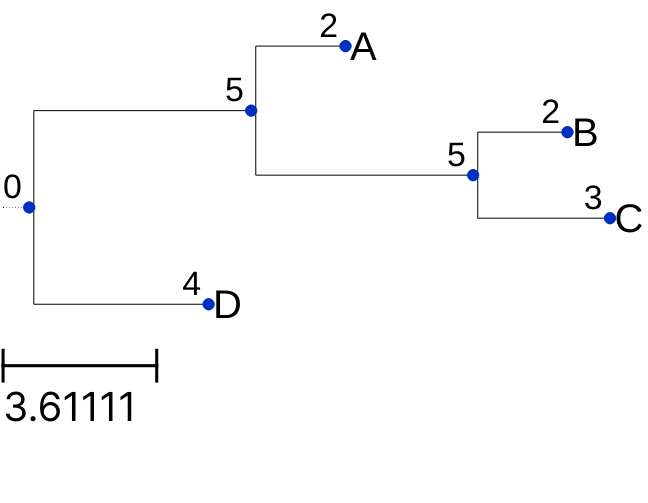

In [11]:
# Affichage de l'arbre au format Newick
newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 5 :** Reécrivez l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](input/tree.png)

In [12]:
def print_newick(newick_tree: str):
    """
    Affiche un arbre newick.

    Args:
        newick_tree (str): La chaine de charactères de l'arbre au format newick.
    """
    t = Tree(newick_tree)
    ts = TreeStyle()
    ts.show_branch_length = True
    
    return t.render('%%inline', w=183, units='mm', tree_style=ts)

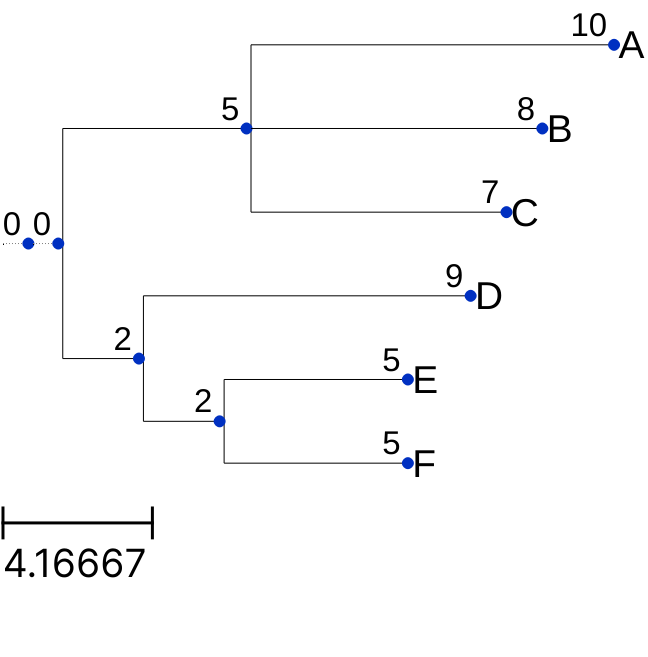

In [13]:
# Affichage de l'arbre au format Newick.
newick_tree = '(((A:10, B:8, C:7):5, (D:9, (E:5, F:5):2):2):0);'
print_newick(newick_tree)


**Exercice 6 :** Expliquer la relation de parenté entre $A$, $B$ et $C$ ? Qu'elles sont les hypothèses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une réponse détaillée.

Réponse : 

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les séquences. À chaque itération, les séquences avec la distance la plus faible sont regroupées puis une nouvelle matrice de distance est calculée avec le nouveau groupe. Cette étape est répétée jusqu'à n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les séquences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les séquences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met à jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calculées en moyennant les distances entre les membres du nouveau groupe et des groupes non modifiés pondéré par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement formé et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final écrit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $(((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 7 :** Implémenter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux données. 

In [14]:
def count_nested_tuple(tuples) -> int:
    """
        Cette fonction calcule le nombre total de tuples imbriqués dans un tuple donné.

        Args :
            tuples (any) : Le tuple dont on souhaite compter le nombre de tuples imbriqués.

        Returns :
            int : Le nombre total de tuples imbriqués dans le tuple donné. Si aucun tuple, renvoie 0.

        Example :
            >> count_nested_tuple(((1, 2), (3, 4)))
            2
    """
    if isinstance(tuples, tuple):
        (t_1, t_2) = tuples
        return 1 + count_nested_tuple(t_1) + count_nested_tuple(t_2)

    else:
        return 0


In [15]:
def upgma_get_min(mat_dist: np.ndarray):
    """
        La fonction upgma_min prend en entrée une matrice de distances mat_dist 
        et retourne les clefs de ce minimum sous forme d'un tuple (min_i, min_j).

        Args:
            mat_dist (ndarray): La matrice de distances qui sera analysée.

        Returns:
            tuple: Les clefs du minimum de la matrice sous forme d'un tuple (min_i, min_j) où 
            min_i et min_j sont les clefs associé au minimum dans la matrice de distance.
    """
    (n, _) = mat_dist.shape
    min_i, min_j = "", ""
    min_val = np.Infinity

    # Cherche le minimum de la matrice
    for i in range(1, n):
        for j in range(1, i):
            if mat_dist[i, j] < min_val:
                min_i, min_j = mat_dist[0, i], mat_dist[0, j]
                min_val = mat_dist[i, j]

    return (min_j, min_i), min_val


def upgma_init_matrix_distance(mat_distance: np.ndarray, min: tuple) -> np.ndarray:
    """
        Initialise la matrice de distance pour l'algorithme UPGMA.

        Args:
            mat_distance (np.ndarray) : La matrice de distance initiale.
            min (tuple) : La valeur minimale (min_i, min_j) dans la matrice de distance.

        Returns:
            np.ndarray : La matrice de distance initialisée pour l'algorithme UPGMA.
    """

    # Récupère les clefs actuelles.
    keys = mat_distance[0, 1:].tolist()
    min_i, min_j = min

    # Supprime les clefs du groupe des minimums
    keys.remove(min_i)
    keys.remove(min_j)

    # Complete the keys
    n = len(keys) + 2
    keys = [f"({n}, {n})"] + [min] + keys

    # Créer et remplie la matrice avec les nouvelles clefs
    matrix = np.zeros((n, n), dtype=object)
    matrix[0] = keys
    matrix[:, 0] = keys

    return matrix


def upgma_compute_distance(mat_distance: np.ndarray, id_min: tuple, id_reste: str, ni: int, nj: int) -> float:
    """
        Calcule la distance dijk pour l'algorithme UPGMA.

        Args:
            mat_distance (np.ndarray) : La matrice de distance.
            id_min (tuple) : Les identificateurs (id_i, id_j) des clefs minimums dans la matrice de distance.
            id_reste (str) : L'identificateur id_k du reste.
            ni (int): La valeur de l'uto pour i dans la formule dijk.
            nj (int): La valeur de l'uto pour j dans la formule dijk.
        
        Returns:
            float : La distance dijk pour l'algorithme UPGMA.
    """

    # Récupère les indices des clefs minimums dans la matrice de distance.
    id_i, id_j = id_min 
    id_k = id_reste

    # Récupére les distances des cases entres (i, reste) et (j, reste).
    d_ik = mat_distance[id_i, id_k]
    d_jk = mat_distance[id_j, id_k]

    # Oblige à avoir ni, nj >= 1.
    ni, nj = max(1, ni), max(1, nj)

    # Renvoie la formule dijk.
    return  (ni*d_ik + nj*d_jk) / (ni + nj)


def upgma_fill_matrix(mat_distance: np.ndarray, matrix_upgma: np.ndarray, newick_tree:dict) -> np.ndarray:
    """
    Remplie la matrice selon l'algorithme UPGMA.

    Args:
        mat_distance (np.ndarray): Matrice de distance initiale.
        matrix_upgma (np.ndarray): Matrice que l'on souhaite remplir, créer à l'aide de la 
        fonction upgma_init_matrix_distance.
        newick_tree (dict): Le dictionnaire contentant les clefs et valeurs des minimums.

    Returns:
        np.ndarray: La matrice de distance upgma remplie.
    """
    (n, _) = matrix_upgma.shape

    # Récupère les clefs des deux matrices de distances.
    keys_shift = mat_distance[0].tolist()
    keys = matrix_upgma[0].tolist()

    # Récupère les clefs des minimums dans la matrices de distance. 
    (min_i, min_j), min_val = upgma_get_min(mat_distance)
    
    # Récupère les indices des clefs dans les matrices respectives.
    id_min_shift = (keys_shift.index(min_i), keys_shift.index(min_j))
    id_min = keys.index((min_i, min_j))
    
    # Remplis la matrices upgma.
    for i in range(1, n):
        for j in range(1, i):

            # Calcul la distance entre (min_i, min_j) et j.
            if j == id_min:
                i_shift = keys_shift.index(keys[i])
                ni, nj = count_nested_tuple(keys[i]), count_nested_tuple(keys[j])
                matrix_upgma[i, j] = upgma_compute_distance(mat_distance, id_min_shift, i_shift, ni, nj)

            # Récupère les distances de la matrice de distance.
            else:
                key_i, key_j = matrix_upgma[0, i], matrix_upgma[j, 0]
                i_shift, j_shift = keys_shift.index(key_i), keys_shift.index(key_j)

                matrix_upgma[i, j] = mat_distance[i_shift, j_shift]
            
            # La matrice est symétrique.
            matrix_upgma[j, i] = matrix_upgma[i, j]
        
    # Ajoute les caractérisque du min dans le dict newick.
    newick_tree[n - 2] = (min_i, min_j, min_val)

    return matrix_upgma


def upgma(mat_distance: np.ndarray) -> tuple:
    """
        Cette fonction implémente l'algorithme UPGMA.

        Args :
            mat_distance : La matrice de distance initiale.

        Returns :
            (numpy.ndarray, dict) : La matrice de distance après l'exécution de l'algorithme UPGMA.
            Le dictionnaire contenant les données pour représenter l'arbre newick.
    """
    (n, _) = mat_distance.shape
    newick_dict = {}

    # Boucle jusqu'à ce qu'il n'y ait plus que 3 lignes dans la matrice de distance.
    while n > 3:
        min,  _= upgma_get_min(mat_distance)
        mat_d = upgma_init_matrix_distance(mat_distance, min)
        mat_d = upgma_fill_matrix(mat_distance, mat_d, newick_dict)
        
        mat_distance = mat_d
        (n, _) = mat_distance.shape
    
    # Ajoute le dernier éléments dans la matrice
    (min_i, min_j), min_val = upgma_get_min(mat_distance)
    newick_dict[n - 3] = (min_i, min_j, min_val)
    
    return mat_distance, newick_dict

In [16]:
def get_newick_rec(newick_dict: dict, label: str):
    """
        Cette fonction génère la représentation de Newick d'une structure arborescente stockée dans 
        un format de dictionnaire.

        Args:
            newick_dict (dict): Une représentation sous forme de dictionnaire de l'arborescence 
                                où les clés sont des étiquettes de nœuds et les valeurs sont des 
                                tuples représentant les enfants de gauche et de droite et la longueur 
                                de l'arête reliant le nœud à son parent.
            label (Any): Une étiquette pour identifier le nœud d'intérêt dans l'arborescence.

        Returns:
            (str, int): Un tuple contenant la représentation de Newick de l'arborescence sous forme de 
            chaîne de caractères et la longueur maximale des arêtes dans l'arbre.
    """
    data = ()

    # Boucle pour trouver les données associées à l'étiquette de noeud d'intérêt
    for k in newick_dict.keys():
        left, right, val = newick_dict[k]
        if (left, right) == label:
            data = newick_dict[k]
            break

    # Séparation des données en composants gauche, droit et valeur
    left, right, val = data
    val /= 2

    # Cas où les deux enfants sont des chaînes de caractères
    if isinstance(left, str) and isinstance(right, str):
        return f"({left}:{val}, {right}:{val})", val

    # Cas où l'enfant gauche est un tuple et l'enfant droit est une chaîne de caractères
    elif isinstance(left, tuple) and isinstance(right, str):
        left_newick, left_val = get_newick_rec(newick_dict, left)
        return f"({left_newick}:{left_val}, {right}:{val})", max(left_val, val)

    # Cas où l'enfant gauche est une chaîne de caractères et l'enfant droit est un tuple
    elif isinstance(left, str) and isinstance(right, tuple):
        right_newick, right_val = get_newick_rec(newick_dict, right)
        return f"({left}:{val}, {right_newick}:{right_val})", max(right_val, val)

    # Cas où les deux enfants sont des tuples
    else:
        left_newick, left_val = get_newick_rec(newick_dict, left)
        right_newick, right_val = get_newick_rec(newick_dict, right)
        return f"({left_newick}:{left_val}, {right_newick}:{right_val})", max(right_val, left_val)


def get_newick(newick_dict: dict) -> str:
    """
        Convertit une représentation de dictionnaire imbriqué d'un arbre en une chaîne de caractères Newick.

        Args:
            newick_dict (dict): Une représentation de dictionnaire d'un arbre.

        Returns:
            str: Une chaîne de caractères Newick représentant l'arbre.
    """
    # On exreait les valeurs left, right et val du premier élément du dictionnaire.
    left, right, val = newick_dict[0]

    # Si la valeur right est un sous-arbre imbriqué
    if isinstance(right, tuple):
        # Création des sous-arbres left et right
        left_newick, left_val = get_newick_rec(newick_dict, left)
        right_newick, right_val = get_newick_rec(newick_dict, right)

        # Combinaison des sous-arbres left et right
        newick = f"({left_newick}:{left_val}, {right_newick}:{right_val});"

    else:
        # Appel récursif de la fonction get_newick pour le sous-arbre left
        left_newick, left_val = get_newick_rec(newick_dict, left)

        # Combinaison du sous-arbre left et de la valeur right
        newick = f"({left_newick}:{left_val}, {right}:{val});"

    return newick


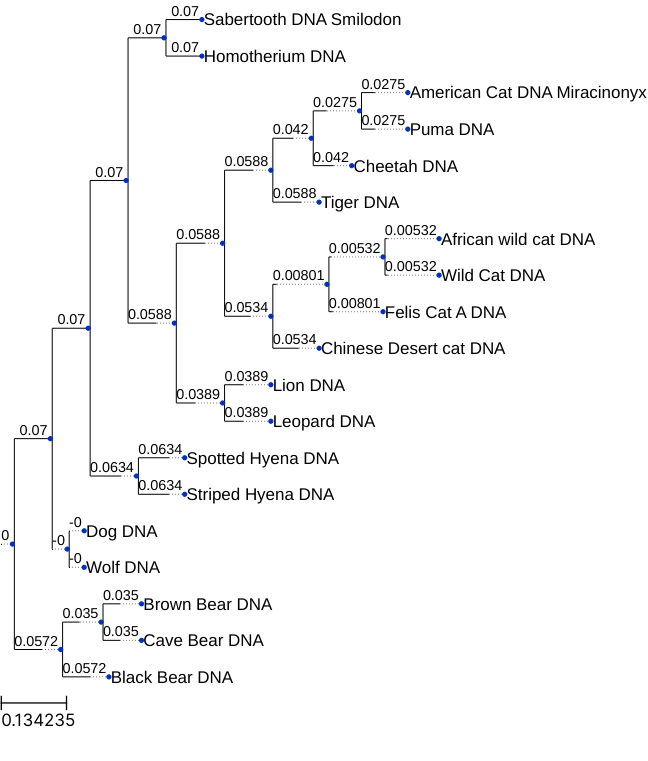

In [17]:
# Affichage du résulats
mat, newdict = upgma(MAT_DIST_FASTA)
newick_tree = get_newick(newdict)

print_newick(newick_tree)

**Exercice 8 :** Quelles sont les hypothèses faites par UPGMA ? Semblent-elles respectées dans le cas présent ?

**Réponse :**
Les hypothèses de la méthode UPGMA sont que l'évolution se produit à un taux constant, que la distance génétique entre les espèces est symétrique et additive. 
Ici, les hypothèses semblent respecté car la matrice de distance est symétrique, la distance entre une même séquence vaut 0.

----
## Enracinement de l'arbre

Après avoir utilisé UPGMA pour réaliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 9 :** Quelle autre méthode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

**Réponse :** 
Il existe une seconde méthode, appelée enracinement par un groupe extérieur. Pour cela, nous avons besoin d'inclure un groupe de séquence homologues au séquences anélysée, qui sont extérieurs au séquences analysée.
Ici, nous ne connaisons pas un tel groupe, donc on ne peut pas utiliser cette méthode.

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylogénique à partir d'une matrice de distance. Il a l'avantage de faire moins d'hypothèse qu'UPGMA sur les données (elles ne sont plus forcément ultramétrique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 10 :** Implémenter l'algorithme du neighbor-joining, appliquer-le aux données puis enraciner l'arbre.

In [18]:
def neighborjoining(mat_distance):
    #premier cycle (deuxième si on compte la matrice de distance initiale)
    matrix = cycle(mat_distance, 'U1', 0)

    c = 2   
    l = [matrix]
    while matrix.shape != (2,2):
        
        matrix = cycle(matrix, 'U'+str(c), 0)
        l.append(matrix)
        #print("cycle number ", c+1, " done")
        c+=1
    
    return l

# fonction pour le petit exemple donné
def neighborjoining_EXAMPLE(mat_distance):
    cycle1 = cycle(mat_distance, 'U1', 1)
    cycle2 = cycle(cycle1, 'U2', 2)    
    cycle3 = cycle(cycle2, 'U3', 3)
    cycle4 = cycle(cycle3, 'U4', 4)

    print("\n","-"*10, "cycle number (initial distance matrix) ", 1, ":", "-"*10, " \n")
    print_mat_dist(mat_distance)  

    c = [cycle1, cycle2, cycle3, cycle4]
    for i in range(4):
        print("-"*22, "cycle number ", i+2, ":", "-"*22, " \n")
        print_mat_dist(c[i])   


def cycle(mat_distance, U, num):
    n = len(mat_distance)
    dS = {} # dictionnaire clés : indice de la sequence et valeurs : somme des distance entre la seq et les autres
    #matrice carrée
    UTOs = n - 1

    # Etape 1 : Pour la somme des distances
    for i in range(1, n):
        somme= 0
        for j in range(1, n): #notre matrice est symétrique
            if i != j: #juste par précaution
                somme += mat_distance[i][j]
        seq = mat_distance[i][0]
        
        dS[seq]=somme/(UTOs-2) 

    # Etape 2 : recherche d'une pair de seq avec M minimale selon l'algo
    dM = {}
    for i in range(1, n):
        for j in range(1, n):
            if i > j:
                seq1 = mat_distance[i][0]
                seq2 = mat_distance[0][j]

                #formule de M(i,j)
                dM[(seq1, seq2)] = mat_distance[i][j] - dS[seq1] - dS[seq2]
    

    #on prend une paire noté I qui a pour valeur M minimale 
    Pair_min = min(dM.values())
    I = ""
    for k in dM.keys():

        #les cas pour le ptit exemple
        if num == 1:
            if dM[k] == Pair_min and (k == ('A', 'B') or k == ('B', 'A')):
                I = k
        elif num == 2:
            if dM[k] == Pair_min and (k == ('D', 'E') or k == ('E', 'D')):
                I = k
        elif num == 3:
            if dM[k] == Pair_min and (k == ('C', 'U1') or k == ('U1', 'C')):
                I = k
        elif num == 4:
            if dM[k] == Pair_min and (k == ('U2', 'U3') or k == ('U3', 'U2')):
                I = k

        #le cas pour notre dataset
        else:
            if dM[k] == Pair_min:
                I = k


    # Etape 3 création de nouveau noeud associé à I
    dU = {}
    keys = list(mat_distance[0][1:])
    i, j = I

    #formule
    dist = mat_distance[keys.index(I[0])+1][keys.index(I[1])+1]
    dU[(i, U)] = dist/2 + (dS[i] - dS[j]) /2
    dU[(j, U)] = dist/2 + (dS[j] - dS[i]) /2
    
    # Etape 4 :
    #graphique à faire

    # Etape 5 : calcul nouvelle distance avec nouveau noeud et création nouvelle matrice
    id_i = keys.index(i)+1
    id_j = keys.index(j)+1
    
    keys.remove(i)
    keys.remove(j)

    n = len(keys) + 2
    keys = [f"({n}, {n})"] + [U] + keys

    matrix = np.zeros((n, n), dtype=object)
    matrix[0] = keys
    matrix[:, 0] = keys
    
    
    for k in range(1, n):
        for l in range(1, k):
            
            # colonne de 'U1'
            if l == 1: 
                #le bon indice pour k
                a = list(mat_distance[0, 0:]).index(keys[k])

                #formule
                matrix[k, l] = (mat_distance[a, id_i] + mat_distance[a, id_j] - mat_distance[id_i, id_j])/2
                
                   
            # Récupère les distances de la matrice de distance.
            else:
                #pour récuperer les bons indices dans la matrice de distance
                a = list(mat_distance[0, 0:]).index(keys[k])
                b = list(mat_distance[0, 0:]).index(keys[l])

                matrix[k, l] = mat_distance[a, b]
            
            # La matrice est symétrique.
            matrix[l, k] = matrix[k, l]
           
    
    return matrix

In [19]:
# L'algo appliqué à un petit exemple : 
matrix3 = np.array([[" ", "A", "B", "C", "D", "E", "F"],
                    ["A",  0,   5,   4,   7,   6,   8 ],
                    ["B",  5,   0,   7,  10,   9,  11 ],
                    ["C",  4,   7,   0,   7,   6,   8 ],
                    ["D",  7,   10,  7,   0,   5,   9 ],
                    ["E",  6,   9,   6,   5,   0,   8 ],
                    ["F",  8,   11,  8,   9,   8,   0 ]], dtype=object)

neighborjoining_EXAMPLE(matrix3)


 ---------- cycle number (initial distance matrix)  1 : ----------  

         | A        | B        | C        | D        | E        | F        | 

A        |        0 | 5.00e+00 | 4.00e+00 | 7.00e+00 | 6.00e+00 | 8.00e+00 | 

B        | 5.00e+00 |        0 | 7.00e+00 | 1.00e+01 | 9.00e+00 | 1.10e+01 | 

C        | 4.00e+00 | 7.00e+00 |        0 | 7.00e+00 | 6.00e+00 | 8.00e+00 | 

D        | 7.00e+00 | 1.00e+01 | 7.00e+00 |        0 | 5.00e+00 | 9.00e+00 | 

E        | 6.00e+00 | 9.00e+00 | 6.00e+00 | 5.00e+00 |        0 | 8.00e+00 | 

F        | 8.00e+00 | 1.10e+01 | 8.00e+00 | 9.00e+00 | 8.00e+00 |        0 | 

---------------------- cycle number  2 : ----------------------  

(6, 6)   | U1       | C        | D        | E        | F        | 

U1       |        0 | 3.00e+00 | 6.00e+00 | 5.00e+00 | 7.00e+00 | 

C        | 3.00e+00 |        0 | 7.00e+00 | 6.00e+00 | 8.00e+00 | 

D        | 6.00e+00 | 7.00e+00 |        0 | 5.00e+00 | 9.00e+00 | 

E        | 5.00e+00 | 6.00e+00 | 5.00

In [20]:
# L'algo appliqué à notre dataset :

m = neighborjoining(MAT_DIST_FASTA)

# affiche les 5 derniers cycles
l = m[-5:]
for i in range(len(l)):
    print("\n")
    print_mat_dist(l[i])



(6, 6)   | U14      | U13      | U9       | U5       | Chinese  | 

U14      |        0 | 2.31e-02 | 2.95e-02 | 6.05e-02 | 7.02e-02 | 

U13      | 2.31e-02 |        0 | 4.13e-02 | 7.99e-02 | 7.18e-02 | 

U9       | 2.95e-02 | 4.13e-02 |        0 | 7.13e-02 | 7.14e-02 | 

U5       | 6.05e-02 | 7.99e-02 | 7.13e-02 |        0 | 9.49e-02 | 

Chinese  | 7.02e-02 | 7.18e-02 | 7.14e-02 | 9.49e-02 |        0 | 



(5, 5)   | U15      | U14      | U13      | U9       | 

U15      |        0 | 1.79e-02 | 2.84e-02 | 2.39e-02 | 

U14      | 1.79e-02 |        0 | 2.31e-02 | 2.95e-02 | 

U13      | 2.84e-02 | 2.31e-02 |        0 | 4.13e-02 | 

U9       | 2.39e-02 | 2.95e-02 | 4.13e-02 |        0 | 



(4, 4)   | U16      | U15      | U9       | 

U16      |        0 | 1.16e-02 | 2.39e-02 | 

U15      | 1.16e-02 |        0 | 2.39e-02 | 

U9       | 2.39e-02 | 2.39e-02 |        0 | 



(3, 3)   | U17      | U16      | 

U17      |        0 | 5.79e-03 | 

U16      | 5.79e-03 |        0 | 



(2, 2)  

/tmp/ipykernel_38270/1423280815.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  dS[seq]=somme/(UTOs-2)
/tmp/ipykernel_38270/1423280815.py:92: RuntimeWarning: invalid value encountered in scalar subtract
  dU[(i, U)] = dist/2 + (dS[i] - dS[j]) /2
/tmp/ipykernel_38270/1423280815.py:93: RuntimeWarning: invalid value encountered in scalar subtract
  dU[(j, U)] = dist/2 + (dS[j] - dS[i]) /2


----
## Bootstrap

Le bootstrap est une méthode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recréer un jeu de données artificiel en tirant n positions dans l'alignement des séquences avec remise, n étant la longueur de l'alignement. On recréer un arbre à partir de ces nouvelles données puis on le compare avec l'arbre obtenu avec les données réelles. Si une branche de l'arbre réelle est présente dans l'arbre artificiel, son bootstrap augmente de 1. On répètera la procédure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 11 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

In [21]:
# À remplir

----
## Conclusion

**Exercice 12 :** Quelles sont vos conclusions par rapport à l'arbre phylogénique de _smilodon_, _homotherium_ et _M. trumani_ ? Comparer les deux méthodes. Comment expliquer les caractéristiques morphologiques similaires entre ces trois espèces ? Une réponse détaillée est attendue.

Réponse :